# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from xgboost.sklearn import XGBRegressor 
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from time import time
from sklearn.pipeline import Pipeline
import traceback

import pickle
from sklearn.externals import joblib

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [4]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN        3         1                    2  
1             9.0       4.0        5         2                    1  
2             9.0       2.0        5         2                    3  
3             9.0       7.0        3         2                    4  
4             9.0       3.0        4         1                    3  

[5 rows x 366 columns]

In [5]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [6]:
azdias_copy = azdias.copy(deep=True)

In [7]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('number of rows and columns - gen. demo. data:',azdias.shape)
print('number of rows and columns - customers of mail order company:',customers.shape)

number of rows and columns - gen. demo. data: (891221, 366)
number of rows and columns - customers of mail order company: (191652, 366)


In [8]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           3.0       5.0         3.0      2.0             6.0   
1         ...           NaN       6.0         6.0      3.0             0.0   
2         ...           4.0      10.0        13.0     11.0             6.0   
3         ...           2.0       6.0         4.0      2.0             NaN   
4         ...           4.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             9.0       7.0        3         1                    4  
1             9.0       NaN        3         1                    4  
2             9.0       2.0        3         2                    4  
3             9.0       7.0        1         1                    4  
4             9.0       3.0        1         1                    3  

[5 rows x 366 columns]

In [9]:
info_attributes = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')
attributes_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')

# Reusing the Feature info provided for the other project
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [10]:
attributes_values.head(6)

Unnamed: 0             Attribute  \
0         NaN              AGER_TYP   
1         NaN                   NaN   
2         NaN                   NaN   
3         NaN                   NaN   
4         NaN                   NaN   
5         NaN  ALTERSKATEGORIE_GROB   

                                    Description  Value  \
0                            best-ager typology     -1   
1                                           NaN      0   
2                                           NaN      1   
3                                           NaN      2   
4                                           NaN      3   
5  age classification through prename analysis   -1, 0   

                      Meaning  
0                     unknown  
1  no classification possible  
2             passive elderly  
3            cultural elderly  
4   experience-driven elderly  
5                     unknown

In [11]:
attr_notna = attributes_values['Attribute'].fillna(method='ffill')
print('Total attributes in DIAS Attributes - Values: ',len(attr_notna))

attributes_values['Attribute'] = attr_notna

Total attributes in DIAS Attributes - Values:  2258


In [12]:
# filtering for the unknowns i.e. 'unknown' or 'no '

attributes_values = attributes_values[(attributes_values['Meaning'].str.contains("unknown") | 
                                       attributes_values['Meaning'].str.contains("no "))]

In [13]:
ls = []
for attr in attributes_values['Attribute'].unique():
    ele = attributes_values.loc[attributes_values['Attribute'] == attr, 'Value'].astype(str).str.cat(sep=',').split(',')
    ls.append(ele)
    
attr_comb = pd.concat([pd.Series(attributes_values['Attribute'].unique()), pd.Series(ls)], axis=1)
attr_comb.columns = ['Attribute', 'Value']
attr_comb.head(5)

Attribute     Value
0              AGER_TYP   [-1, 0]
1  ALTERSKATEGORIE_GROB  [-1,  0]
2              ALTER_HH       [0]
3             ANREDE_KZ  [-1,  0]
4              BALLRAUM      [-1]

In [14]:
# Get the list of non nan Attributes

attr_notna = attributes_values[attributes_values['Attribute'].notna()]
print('Total attributes in DIAS Attributes - Values: ',len(attr_notna))

print('Total attributes in DIAS info file:',len(set(info_attributes['Attribute'])))

# List of Attributes with given unknowns
print('Unknown values in DIAS Attributes - Values: ',len(set(attr_comb['Attribute'])))

Total attributes in DIAS Attributes - Values:  302
Total attributes in DIAS info file: 313
Unknown values in DIAS Attributes - Values:  292


### Step 0.1: Combine both old and new features info files with unknowns  
- and then remove the duplicate entries
- and also remove the columns from info files which are not in azdias.



In [15]:
# combining missing values from old and new files.

new_attr = list(attr_comb['Attribute'])
new_vals = list(attr_comb['Value'])

n_val = []
for i in new_vals:
    string = str(i).replace("'", "") 
    n_val.append(string)

old_attr = list(feat_info['attribute'])
old_vals = list(feat_info['missing_or_unknown'])

comb_attr = old_attr + new_attr
comb_vals = old_vals + n_val

combined_feat_info = pd.DataFrame(list(zip(comb_attr, comb_vals)),columns=['Attributes', 'Missing'])

In [16]:
# Remove duplicates in combined unknowns 

duplicate_attr = combined_feat_info.duplicated(subset=['Attributes'])

# Print duplicates
# if duplicate_attr.any():
#     print(combined_feat_info.loc[duplicate_attr], end='\n\n')

# drop duplicates in Attributes
combined_feat_info.drop_duplicates(subset ="Attributes",inplace=True)
combined_feat_info.shape

(317, 2)

In [17]:
# Replacing e.g. D19_BIO_OEKO_RZ with D19_BIO_OEKO --> removing _RZ
import re

info_attributes['Attribute'] = info_attributes['Attribute'].apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)
combined_feat_info['Attributes'] = combined_feat_info['Attributes'].apply(lambda x: re.sub('_RZ', '', x) if 'D19' in x else x)

In [18]:
# Remove columns from combined unknowns  which are not in azdias

not_in_azdias =  list(set(combined_feat_info['Attributes']) - set(azdias.columns))
print(len(not_in_azdias), not_in_azdias)

# Remove attributes
for i in not_in_azdias:
    combined_feat_info = combined_feat_info[combined_feat_info.Attributes != i]

9 ['WACHSTUMSGEBIET_NB', 'D19_KK_KUNDENTYP', 'D19_BUCH', 'KBA13_CCM_1400_2500', 'SOHO_FLAG', 'HAUSHALTSSTRUKTUR', 'CAMEO_DEUINTL_2015', 'GEOSCORE_KLS7', 'BIP_FLAG']


In [19]:
not_in_attr =  set(attr_notna['Attribute']) - set(azdias.columns)

print('Azdias attributes which are not in DIAS Attributes - Values:', len(not_in_attr))
print(len(set(attr_notna['Attribute'])), len(set(azdias.columns)))

Azdias attributes which are not in DIAS Attributes - Values: 42
292 366


In [20]:
not_in_az_infos = list(set(info_attributes['Attribute']) - set(azdias.columns))

print('Attributes not in DIAS Info file:', len(not_in_az_infos), not_in_az_infos)

Attributes not in DIAS Info file: 17 ['WACHSTUMSGEBIET_NB', 'GKZ', 'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24', 'D19_KK_KUNDENTYP', 'EINWOHNER', 'GEOSCORE_KLS7', 'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24', 'PLZ8', 'SOHO_FLAG', 'KBA13_CCM_1400_2500', 'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24', 'PLZ', 'HAUSHALTSSTRUKTUR', 'CAMEO_DEUINTL_2015', 'D19_BUCH', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24', 'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24']


In [21]:
# Removing info attributes which are not in azdias

for i in not_in_az_infos:
    info_attributes = info_attributes[info_attributes.Attribute != i]

In [22]:
attr_not_in_infos = list(set(combined_feat_info['Attributes']) - set(info_attributes['Attribute']))
print('Attributes not in DIAS Info file:', len(attr_not_in_infos), attr_not_in_infos)

Attributes not in DIAS Info file: 16 ['D19_VERSAND_ANZ_12', 'D19_LOTTO', 'D19_VERSI_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_BANKEN_ANZ_24', 'D19_GESAMT_ANZ_24', 'CAMEO_INTL_2015', 'D19_VERSI_ANZ_24', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_12', 'KBA13_CCM_3000', 'D19_GESAMT_ANZ_12', 'SOHO_KZ', 'D19_VERSAND_ANZ_24', 'KK_KUNDENTYP', 'KBA13_CCM_3001']


In [23]:
info_attributes.head()

Unnamed: 0 Information level             Attribute  \
0         NaN               NaN              AGER_TYP   
1         NaN            Person  ALTERSKATEGORIE_GROB   
2         NaN               NaN             ANREDE_KZ   
3         NaN               NaN         CJT_GESAMTTYP   
4         NaN               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative househo...

In [24]:
print('Finally, {} combined unique features are encoded as missing values'.format(combined_feat_info['Attributes'].nunique()))

Finally, 308 combined unique features are encoded as missing values


In [25]:
# List 

no_info_feats =  set(azdias.columns) - set(info_attributes['Attribute'])
print(len(no_info_feats), no_info_feats)

70 {'VK_DISTANZ', 'FIRMENDICHTE', 'CJT_TYP_3', 'CJT_KATALOGNUTZER', 'D19_BANKEN_ANZ_24', 'KBA13_GBZ', 'CAMEO_INTL_2015', 'ALTER_KIND4', 'KBA13_ANTG2', 'KOMBIALTER', 'VHN', 'KBA13_BAUMAX', 'KBA13_ANTG4', 'KBA13_CCM_3000', 'SOHO_KZ', 'D19_VERSAND_ANZ_24', 'RT_KEIN_ANREIZ', 'STRUKTURTYP', 'D19_LETZTER_KAUF_BRANCHE', 'VK_ZG11', 'CJT_TYP_5', 'HH_DELTA_FLAG', 'D19_KONSUMTYP_MAX', 'AKT_DAT_KL', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_ANTG3', 'D19_BUCH_CD', 'VERDICHTUNGSRAUM', 'ALTER_KIND1', 'CJT_TYP_2', 'D19_GESAMT_ANZ_12', 'MOBI_RASTER', 'EINGEFUEGT_AM', 'KONSUMZELLE', 'VK_DHT4A', 'D19_SOZIALES', 'ANZ_KINDER', 'UMFELD_JUNG', 'ALTERSKATEGORIE_FEIN', 'DSL_FLAG', 'D19_VERSI_ANZ_12', 'D19_VERSI_ONLINE_QUOTE_12', 'RT_UEBERGROESSE', 'GEMEINDETYP', 'D19_BANKEN_ANZ_12', 'CJT_TYP_1', 'CJT_TYP_6', 'D19_VERSI_ANZ_24', 'ALTER_KIND3', 'ALTER_KIND2', 'KK_KUNDENTYP', 'EINGEZOGENAM_HH_JAHR', 'KBA13_HHZ', 'KBA13_CCM_3001', 'D19_VERSAND_ANZ_12', 'KBA13_CCM_1401_2500', 'KBA13_KMH_210', 'LNR', 'D19_LOTTO', 'VHA', 

In [26]:
# Remove '[]' and split with ',' and filter based on data types, 2nd check for empty, and then 
# check for [-1.0, 'X'], ['XX'], [-1.0, 'XX']

import string

def format_unknowns(attr, missings, azdias):
    
    type_is =[]
    for data in attr.tolist():
        try:
            type_is.append(azdias[data].dtypes)
        except:
            print('not in azdias', data)

    nan_list = []   # to get the nan check for each attribute
    unk_list = []   # to save all nan checks for all attributes respectively
    etc_list = []   # to save -1, X etc.
    type_index = 0

    for chks in missings:

        chks = str(chks)
        chks = chks.replace('[','').replace(']','').split(',')

        nan_list = chks

        try:
            if type_is[type_index] == 'int64':
                nan_list = list(map(int, nan_list)) 
                unk_list.append(nan_list)

            elif type_is[type_index] == 'float64':
                nan_list = list(map(float, nan_list)) 
                unk_list.append(nan_list)

            elif type_is[type_index] == 'O':

                if nan_list == ['XX']:
                    unk_list.append(['XX'])

                elif nan_list == ['-1']:
                    unk_list.append(['-1'])

                elif '-1' and 'XX' in nan_list:
                    etc_list = [-1.0, 'XX']
                    unk_list.append(etc_list)

                elif '-1' and 'X' in nan_list:
                    etc_list = [-1.0, 'X']
                    unk_list.append(etc_list)
            else:
                print('fix it!', type_is[type_index], nan_list)

        except:
            try:
                if nan_list == ['']:
                    unk_list.append(['nan'])

                else:
                    ('Its something new', nan_list)               

            except:
                print('exception')
                unk_list.append('exception')

        type_index +=1

    print(len(unk_list))
    print(unk_list)
    
    return unk_list

In [27]:
# get the formatted unknowns

missings = combined_feat_info['Missing']
attr = combined_feat_info['Attributes']

# Formatting the unknowns
unk_list = format_unknowns(attr, missings, azdias)

combined_feat_info['Missing'] = pd.Series(unk_list)

308
[[-1, 0], [-1, 0, 9], [-1, 0], [0.0], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [0], ['nan'], ['nan'], [-1, 0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [-1, 0], [-1, 0], [0.0], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1], [-1.0], [-1.0, 0.0], [-1], [-1, 9], [0.0], ['nan'], ['nan'], [-1.0, 0.0], [-1.0], [-1.0, 0.0], [-1.0, 0.0], [0.0], ['nan'], [-1.0, 0.0], ['nan'], [0.0], ['-1'], [-1.0], [-1.0, 'X'], ['XX'], [-1.0, 'XX'], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0, 0.0], [-1.0, 0.0], [-1.0], [-1.0], [-1.0], ['nan'], [-1.0, 0.0], ['nan'], ['nan'], [-1.0, 0.0], ['nan'], [-1.0], [-1.0], [-1.0], [-1.0], [-1.0, 0.0], [-1.0], [-1.0], [-1.0, 9.0], [-1.0, 0.0], [-1.0, 9.0], [0], [0], [10], [0], [0], [0], [10], [10], [0.0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [10], [10], [10], [0.0], [0], [0], [0], [0], [0], [0.0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [10], [0], [10], [10], [0

In [28]:
#print(combined_feat_info['Missing'])
combined_feat_info.shape

(308, 2)

In [30]:
# drop the nans in the combined features

combined_feat_info = combined_feat_info[combined_feat_info['Missing'].notna()]
print(combined_feat_info.shape)

# save it for later time saving
combined_feat_info.to_pickle('data/combined_feat_info_copy.pkl')

(276, 2)


In [194]:
#azdias_copy = azdias.copy(deep=True)
customers_copy = customers.copy(deep=True)
c_good = replace_nans(customers_copy, feat_info_pickle)
#a_good, anans_all_after, arate = replace_nans(azdias_copy, feat_info_pickle)

In [5]:
# replace with nans

def replace_nans(df, combined_feat_info):
    u_index = 0
    
    missings = list(combined_feat_info['Missing'])
    attr = combined_feat_info['Attributes']

    for x in attr:

        try:        
            if ['nan'] != missings[u_index]:

                for i in missings[u_index]:
                    df[x] = df[x].replace({i:np.nan})
        except:
            print(x, missings[u_index])

        u_index +=1
            
    return df

#azdias_good, nans_all_after = replace_nans(azdias_good, missings)

In [213]:
nans_all_after = []
rate = []
for z in c_good:
    tot = c_good[z].isna().sum()
    nans_all_after.append(tot)
    rate.append((tot/c_good.shape[0])*100)   
    
#tot_points = azdias.shape[0]*azdias.shape[1]
print('Before replacement:',len(nans_all_after), nans_all_after) 

Before replacement: 366 [0, 96738, 46596, 68747, 179886, 186552, 190377, 191416, 51842, 52377, 52110, 46596, 46596, 49927, 46596, 50499, 49959, 50554, 50554, 50554, 3213, 3213, 3213, 3213, 3213, 3213, 3213, 3213, 180150, 173701, 0, 166726, 175064, 187347, 0, 0, 184858, 176243, 154242, 137848, 0, 0, 0, 183539, 160837, 172916, 166363, 179969, 111999, 91722, 0, 0, 0, 134576, 143537, 132811, 153651, 47697, 0, 139367, 0, 47697, 135978, 0, 0, 134825, 145113, 163720, 76573, 47697, 0, 0, 0, 0, 159544, 0, 0, 47697, 168650, 183788, 122306, 0, 23459, 36573, 18669, 48924, 0, 0, 0, 0, 0, 0, 47697, 0, 0, 0, 49927, 49927, 46596, 49959, 85283, 0, 0, 0, 0, 0, 0, 0, 49927, 49927, 49927, 93024, 50476, 3213, 0, 48990, 53742, 2968, 49959, 56913, 56913, 56913, 56913, 56851, 55980, 55980, 55980, 55980, 56914, 109535, 56913, 56913, 56913, 56913, 56913, 56913, 55982, 56913, 56913, 56913, 56913, 56913, 51218, 56913, 56913, 56913, 56913, 56913, 56913, 56913, 56913, 56913, 56913, 55980, 55980, 55980, 55980, 55980

In [28]:
nan_alls_before = []
for z in azdias:
    nan_alls_before.append(azdias[z].isna().sum())
    
#tot_points = azdias.shape[0]*azdias.shape[1]
print('Before replacement:',len(nan_alls_before), nan_alls_before) 

Before replacement: 366 [0, 0, 73499, 73499, 810163, 861722, 885051, 890016, 262947, 93148, 97008, 73499, 73499, 93148, 73499, 97216, 93740, 98979, 98979, 98979, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 4854, 0, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 257113, 0, 0, 0, 257113, 257113, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 0, 0, 0, 257113, 0, 0, 0, 93148, 93148, 73499, 93740, 654153, 0, 0, 0, 0, 0, 0, 0, 93155, 93148, 93155, 0, 97274, 4854, 0, 0, 107602, 18348, 93740, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 93148, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 133324, 93148, 133324, 133324, 133324, 133324, 133324, 133324, 13332

In [55]:
tot_points = azdias.shape[0]*azdias.shape[1]
print('Before replacement:')#,len(nan_alls), nan_alls)
print( 'sum is:', sum(nan_alls_before), 'percenatge is:', (sum(nan_alls_before)/tot_points)*100 )

print('After replacement:')#,len(nans_all_after), nans_all_after) 
print( 'sum is:', sum(nans_all_after), 'percenatge is:', (sum(nans_all_after)/tot_points)*100 )
#print( 'sum is:', sum(nan_alls_after), 'percenatge is:', (sum(nan_alls_after)/tot_points)*100 )

Before replacement:
sum is: 33492923 percenatge is: 10.2680164156
After replacement:
sum is: 47513675 percenatge is: 14.5663964553


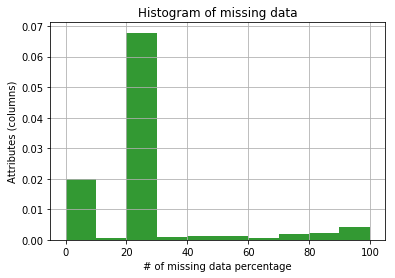

In [214]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

x = rate

# the histogram of the data
n, bins, patches = plt.hist(x, density=True, facecolor='g', alpha=0.8)

plt.xlabel('# of missing data percentage')
plt.ylabel('Attributes (columns)')
plt.title('Histogram of missing data')
plt.grid(True)
plt.show()

In [70]:
c_ind_above = np.argwhere(np.asarray(nans_all_after) > 200000)
c_ind_above = list(map(int, c_ind_above))
print('column indices to drop: ',c_ind_above, len(c_ind_above))
print(list(azdias_copy.iloc[:0, c_ind_above]))

[0, 11, 40, 43, 47, 64, 85, 86, 88, 89, 90, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 109, 110, 111, 112, 113, 115, 118, 119, 120, 121, 126, 129, 130, 131, 136] 37


In [215]:
# Tested for customers

c_ind_above = np.argwhere(np.asarray(rate) > 30)
c_ind_above = list(map(int, c_ind_above))
print('column indices to drop: ',c_ind_above, len(c_ind_above))
print(list(azdias_copy.iloc[:0, c_ind_above]))

column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 301, 326, 349] 43
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'KKK', 'REGIOTYP', 'TITEL_KZ']


#### Dicussion - Dropped Columns:  
As observed from the histogram, there are many columns(see mentioned above) with >200000 NaNs in the columns therefore they were removed from the azdias.

In [59]:
# Drop the columns from azdias

azdias_copy.drop(azdias_copy.columns[c_ind_above], axis=1, inplace=True)
azdias_copy.shape

(891221, 329)

In [71]:
# Drop the columns from combined feat_infos as well

# combined_feat_info_copy = combined_feat_info.copy(deep=True)
# combined_feat_info_copy.drop(combined_feat_info_copy.columns[c_ind_above], axis=1, inplace=True)
# combined_feat_info_copy.shape

In [56]:
# How much data is missing in each row of the dataset?

rows_n = []
for i in range(len(azdias_copy.index)) :
    rows_n.append(azdias_copy.iloc[i].isnull().sum())
    if i % 150000 == 0:
        print("Nan in row ", i , " : " ,  rows_n[i])
        
print(rows_n[:10])
print(len(rows_n))

Nan in row  0  :  265
Nan in row  150000  :  19
Nan in row  300000  :  38
Nan in row  450000  :  40
Nan in row  600000  :  28
Nan in row  750000  :  47
[265, 41, 33, 39, 16, 28, 36, 35, 40, 22]
891221


891221 35


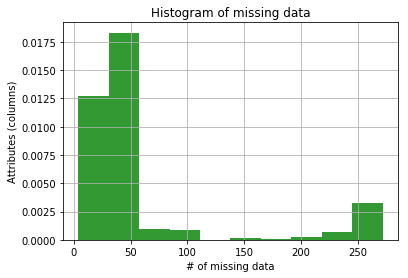

In [57]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
print(len(rows_n), rows_n[880000])
y = rows_n

# the histogram of the data
n, bins, patches = plt.hist(y, density=True, facecolor='g', alpha=0.8)

plt.xlabel('# of missing data')
plt.ylabel('Attributes (rows)')
plt.title('Histogram of missing data')
plt.grid(True)
plt.show()

In [59]:

# # Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 25 # interpreted from the histogram

r_ind_above = np.argwhere(np.asarray(rows_n) > threshold)
r_ind_above = list(map(int, r_ind_above))
print(r_ind_above[:10], len(r_ind_above))

r_ind_below = list(np.argwhere(np.asarray(rows_n) < threshold))
r_ind_below = list(map(int, r_ind_below))
print(r_ind_below[:10], len(r_ind_below))

[0, 11, 12, 13, 14, 15, 17, 20, 23, 24] 148519
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 742168


In [61]:
azdias_bad = azdias_row.iloc[r_ind_above ,:]
azdias_good = azdias_row.iloc[r_ind_below ,:]

print(azdias_good.shape)
print(azdias_bad.shape)

(742168, 329)
(148519, 329)


#### Dicussion - Dropped Rows:  
As observed from the histogram, there are many rows with NaNs with a threshold of 60 therefore they were removed from the azdias as well.

In [11]:
#azdias_good.to_pickle('data/azdias_good.pkl')
#combined_feat_info_copy.to_pickle('data/combined_feat_info_copy.pkl')

#customers.to_pickle('data/customers.pkl')
#azdias_pickle = pd.read_pickle('data/azdias_good.pkl')
feat_info_pickle = pd.read_pickle('data/combined_feat_info_copy.pkl')

### Step 0.2: Select, Re-Encode and Re-Engineer Features  
- Special handling is necessary for the variable types: categorical and mixed.
- Decision to be made on whether to keep, drop, or re-encode each. Then, in the last part, a new data frame with only the selected and engineered columns will be created.




In [6]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def categoricals_check(azdias_pickle, feat_info):    
    multi_level = []
    binary = []
    reencoded = []

    categoricals = feat_info[feat_info['type'].str.contains('categorical')]

    for i in categoricals.attribute:

        try:
            if len(azdias_pickle[i].value_counts()) == 2:
                try:
                    if float(str(azdias_pickle[i].value_counts())[0]):
                        binary.append(i)
                    else:
                        binary.append(i)
                except:
                    reencoded.append(i)
                    print('non-numeric binary - needs re-encoding:\n',azdias_pickle[i].value_counts())


            elif len(azdias_pickle[i].value_counts()) > 2:
                multi_level.append(i)
        except:
            print('key probably already removed from azdias:', i)

    print('Binary:      ', binary, len(binary))
    print('Multi_level: ', multi_level, len(multi_level))
    print('Reencoded:   ', reencoded, len(reencoded))
    
    return binary, multi_level, reencoded

#binary, multi_level, reencoded = categoricals_check(azdias_pickle, feat_info)

In [7]:
# reencode and engineering...
# fix OST_WEST_KZ

def binary_numeric(df_good):
    
    binary_numeric = []

    for k in df_good['OST_WEST_KZ']:
        if k == 'W':
            binary_numeric.append(0)
        else:
            binary_numeric.append(1)
    
    df_good.drop(['OST_WEST_KZ'],axis=1)
    df_good['OST_WEST_KZ'] = binary_numeric
    
    print('OST_WEST_KZ fixed')
    return df_good

#df_good = binary_numeric(azdias_pickle)

In [8]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def praegende_fix(azdias_good):

    avant = [2, 4, 6, 7, 9, 11, 13, 15]
    decade = []
    movement = []

    for i in azdias_good['PRAEGENDE_JUGENDJAHRE']:
        if i in avant:
            movement.append(0)
        else:
            movement.append(1)

    # for decade: 1-2,3-4,5-7,8-9,10-13, 14-15

    for j in azdias_good['PRAEGENDE_JUGENDJAHRE']:
        if j in [1,2]:
            decade.append(0)
        elif j in [3,4]:
            decade.append(1)
        elif j in range(5, 8):
            decade.append(2)
        elif j in [8,9]:
            decade.append(3)
        elif j in range(10, 14):
            decade.append(4)
        elif j in [14,15]:
            decade.append(5)
        else:
            decade.append(np.nan)
    
    azdias_good['PRAEGENDE_JUGENDJAHRE_D'] = decade
    azdias_good['PRAEGENDE_JUGENDJAHRE_M'] = movement
    
    #azdias_good.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    
    print('PRAEGENDE_JUGENDJAHRE can be deleted')

    return azdias_good

#azdias_good = praegende_fix(df_good)        

In [9]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def cameo_fix(azdias_good):
    wealth = []
    life = []

    for i in azdias_good['CAMEO_INTL_2015']:
        if i is not np.nan:
            wealth.append(str(i)[0])
            life.append(str(i)[1])
        else:
            wealth.append(np.nan)
            life.append(np.nan)

    azdias_good['CAMEO_INTL_2015_W'] = wealth
    azdias_good['CAMEO_INTL_2015_L'] = life
    
    #azdias_good.drop('CAMEO_INTL_2015',axis=1)
    
    print('CAMEO_INTL_2015 can be deleted')
    
    return azdias_good

#azdias_good = cameo_fix(azdias_good)

In [10]:
def wohnlage_fix(df_good):
    
    new = []
    rural = [7,8]
    neigh = [1,2,3,4,5]

    for k in df_good['WOHNLAGE']:
        if k in neigh:
            new.append(0)
        elif k in rural:
            new.append(1)
        else:
            new.append(np.nan)
    
    #df_good.drop(['WOHNLAGE'],axis=1)
    df_good['NEIGHBOUR_RURAL'] = new
    
    print('WOHNLAGE can be deleted')
    return df_good

#azdias_good = wohnlage_fix(azdias_good)
#azdias_good['NEIGHBOUR_RURAL'].value_counts()

In [11]:
def baumax_fix(df_good):
    
    family = []
    business = []

    for k in df_good['PLZ8_BAUMAX']:
        if k == 5:
            business.append(1)
            family.append(np.nan)
        elif k > 0 and k < 5:
            family.append(k)
            business.append(0)
        else:
            family.append(np.nan)
            business.append(np.nan)
    
    df_good['PLZ8_BAUMAX_Family'] = family
    df_good['PLZ8_BAUMAX_Business'] = business
    
    print('PLZ8_BAUMAX can be deleted')
    return df_good

#azdias_good = baumax_fix(azdias_good)

In [12]:
def eingefugt_fix(df_good):
    
    eingefugt = []
    for i in df_good['EINGEFUEGT_AM']:
        if i is not np.nan:
            x = str(i)[:4]
            eingefugt.append(int(x))
        else:
            eingefugt.append(np.nan)
            
    df_good['EINGEFUEGT_AM_New'] = pd.Series(eingefugt)
    
    print('EINGEFUEGT_AM is fixed')
    return df_good

#azdias_good = eingefugt_fix(azdias_good)
#azdias_good['EINGEFUEGT_AM_New'].value_counts()

In [13]:
# Engineer and reencode
def engineer_reencode(df, mls, feat_info):
    
    df = binary_numeric(df)
    df = praegende_fix(df)
    df = cameo_fix(df)
    df = wohnlage_fix(df)
    df = baumax_fix(df)
    df = eingefugt_fix(df)
    
    for_dummies, for_delete = filter_multis(df, mls)
    df = drop_extra_cols(df, for_delete, feat_info)
    
    return df, for_dummies
#df , for_dummies = engineer_reencode(df, multi_level)

In [14]:
# filtering the multi_levels for get_dummies to to_delete

def filter_multis(df, multi_level):
    for_delete = []
    for_dummies = []
    for i in multi_level:
        try:
            s = df[i].value_counts()
            #print(s)

            if len(s) < 10:
                for_dummies.append(i)
            else:
                for_delete.append(i)
        except:
            print(i, 'key already dropped!')
            
    print('For get_dummies:    ',for_dummies, len(for_dummies))        
    print('To delete:          ', for_delete, len(for_delete))   
    
    return for_dummies, for_delete

In [15]:
# Delete all un necessary features

def drop_extra_cols(df, deletes, feat_info):
    
    mixed = feat_info[feat_info['type'].str.contains('mixed')]
    to_delete = ['VERDICHTUNGSRAUM', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM']

    to_delete = to_delete + list(mixed.attribute) + list(deletes)
    print('Columns to delete: ',to_delete)

    for i in list(to_delete):
        try:
            #print(i)
            df.drop(i,axis=1,inplace=True)
        except:
            print(i, 'already deleted in the previous steps')
    
    return df

### Summary: Select and Re-Encode Features  
- OST_WEST_KZ reencoded with 'W' = 0, else 1
- PRAEGENDE_JUGENDJAHRE_D and PRAEGENDE_JUGENDJAHRE_M created from PRAEGENDE_JUGENDJAHRE based on 'decade' and 'movement' info.
- NEIGHBOUR_RURAL is created from WOHNLAGE based on rural and neighbourhood info.
- CAMEO_INTL_2015_W and CAMEO_INTL_2015_L created from CAMEO_INTL_2015 based on wealth and life info.
- PLZ8_BAUMAX_Family and PLZ8_BAUMAX_Business created from PLZ8_BAUMAX based on the info family and business info.
- Remaining 'mixed' types are removed from the dataset because of many 0s - also the orignal features were removed as the encoded and engineered feature were added.
- VERDICHTUNGSRAUM, ANZ_KINDER, CAMEO_DEU_2015 also removed because of so many multi levels.
- ANZ_TITEL, ANZ_HH_TITEL dropped because of many 0s.
- LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB dropped because of complex data.


In [16]:
#azdias_good['KBA05_BAUMAX'].value_counts()

In [17]:
# get dummy variables for multi_level features
def make_dummies(df, d):
    
    ls = []
    
    # the following features looked like categoricals as well
    dummies = ['AKT_DAT_KL','GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST',
               'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER']
    dummies = dummies + d
    print('Performing get_dummies on the following:', dummies)
    
    # get dummies
    for i in dummies:
        try:
            dummy = pd.get_dummies(df[i], prefix = i)
            df = pd.concat([df, dummy], axis = 1)
            ls.append(i)
        except:
            print(i, 'already dropped in the previous analysis')

    df.drop(ls, axis=1, inplace = True)
    
    print('***get_dummies finished!')
    
    return df


In [21]:
#azdias_dummy.shape

In [194]:
azdias_good.shape

(742168, 324)

In [14]:
#azdias_dummy.to_pickle('data/azdias_dummy.pkl')
azdias_dummy_pkl = pd.read_pickle('data/azdias_dummy.pkl')

In [42]:
azdias_dummy_pkl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742168 entries, 1 to 891220
Columns: 412 entries, ALTER_HH to KBA05_MAXSEG_9.0
dtypes: float64(264), int64(40), object(4), uint8(104)
memory usage: 1.8+ GB


In [18]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

def do_impute(df_imputed):
    obj_delete = []
    
    imp_mean = Imputer(missing_values="NaN", strategy="most_frequent", axis = 0)

    for i in df_imputed:
        try:
            if df_imputed[i].isna().sum() != 0:
                #print(i)
                df_imputed[i] = imp_mean.fit_transform(df_imputed[[i]]).ravel()
            
        except:
            print(i, df_imputed[i].dtypes)
            obj_delete.append(i)
            
    return imp_mean, df_imputed, obj_delete

#imputer, df_imputed = do_impute(azdias_dummy_pkl)
#imputer, df_imputed = do_impute(azdias_good)
#imputer, df_imputed, for_dummies = do_impute(df_cust)

In [19]:
def clean_data(df, df_feat, feat_info):
    """
    Perform feature trimming, re-encoding, engineering and imputing for demographics
    data
    
    INPUT: Demographics DataFrame and Features info
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # convert missing value codes into NaNs, ...
    nan_alls_before = []
    for z in df:
        nan_alls_before.append(df[z].isna().sum())
    
    tot_points = df.shape[0]*df.shape[1]
    print('Before replacement:')
    print( 'sum is:', sum(nan_alls_before), 'percenatge is:', (sum(nan_alls_before)/tot_points)*100 )
        
    df_nan = replace_nans(df, df_feat)
    
    nans_all_after = []
    rate = []
    for z in df_nan:
        tot = df_nan[z].isna().sum()
        nans_all_after.append(tot)
        rate.append((tot/df_nan.shape[0])*100)   
          
    print('After replacement:')
    print( 'sum is:', sum(nans_all_after), 'percenatge is:', (sum(nans_all_after)/tot_points)*100 )
    
    # drop columns with >200000 NaNs or >30 percent rate
    c_ind_above = np.argwhere(np.asarray(rate) > 30)
    c_ind_above = list(map(int, c_ind_above))
    print('column indices to drop: ',c_ind_above, len(c_ind_above))
    
    print(list(df.iloc[:0, c_ind_above]))
#     columnsData = df.iloc[: , c_ind_above]
#     print(columnsData.columns)
    df.drop(df.columns[c_ind_above], axis=1, inplace=True)
    print(df.shape)
    
    # drop rows with > 25 NaNs
    rows_n = []
    for i in range(len(df.index)) :
        rows_n.append(df.iloc[i].isnull().sum())
        if i % 150000 == 0:
            print("Nan in row ", i , " : " ,  rows_n[i])

    print(rows_n[:10])
    print(len(rows_n))
    threshold = 25 # interpreted from the histogram

    r_ind_above = np.argwhere(np.asarray(rows_n) > threshold)
    r_ind_above = list(map(int, r_ind_above))
    print(r_ind_above[:10], len(r_ind_above))

    r_ind_below = list(np.argwhere(np.asarray(rows_n) < threshold))
    r_ind_below = list(map(int, r_ind_below))
    print(r_ind_below[:10], len(r_ind_below))
    
    azdias_bad = df.iloc[r_ind_above ,:]
    azdias_good = df.iloc[r_ind_below ,:]

    print(azdias_good.shape)
    print(azdias_bad.shape)
    
    # select, re-encode, and engineer column values.
    binary, multi_level, reencoded = categoricals_check(azdias_good, feat_info)
    
    df , for_dummies = engineer_reencode(azdias_good, multi_level, feat_info)
    
    # do imputation
    imputer, df_imputed, obs_delete = do_impute(df)
    
    
    # Return the cleaned dataframe.
    return df_imputed, for_dummies   
    

In [233]:
azdias_copy = azdias.copy(deep=True)

In [37]:
adf_imputed, afor_dummies = clean_data(azdias_copy, feat_info_pickle, feat_info)

Before replacement:
sum is: 33492923 percenatge is: 10.2680164156
After replacement:
sum is: 59466344 percenatge is: 18.23075867
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 349] 41
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992',

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


OST_WEST_KZ fixed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRAEGENDE_JUGENDJAHRE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CAMEO_INTL_2015 can be deleted
WOHNLAGE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PLZ8_BAUMAX can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


EINGEFUEGT_AM is fixed
For get_dummies:     ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'] 9
To delete:           ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'] 4
Columns to delete:  ['VERDICHTUNGSRAUM', 'LNR', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


KBA05_BAUMAX already deleted in the previous steps
CAMEO_DEU_2015 already deleted in the previous steps
ALTERSKATEGORIE_FEIN


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


ANZ_HAUSHALTE_AKTIV
ARBEIT
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_KONSUMTYP
D19_LETZTER_KAUF_BRANCHE
D19_LETZTER_KAUF_BRANCHE object
D19_SOZIALES
D19_TELKO_ONLINE_QUOTE_12
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ONLINE_QUOTE_12
EWDICHTE
FIRMENDICHTE
GEBAEUDETYP_RASTER
GEMEINDETYP
HEALTH_TYP
HH_DELTA_FLAG
INNENSTADT
KBA05_AUTOQUOT
KBA05_HERSTTEMP
KKK
KONSUMNAEHE
KONSUMZELLE
LP_FAMILIE_GROB
LP_STATUS_GROB
NATIONALITAET_KZ
ONLINE_AFFINITAET
ORTSGR_KLS9
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_GBZ
PLZ8_HHZ
REGIOTYP
RELAT_AB
RETOURTYP_BK_S
RT_KEIN_ANREIZ
RT_SCHNAEPPCHEN
RT_UEBERGROESSE
SHOPPER_TYP
STRUKTURTYP
UMFELD_ALT
UMFELD_JUNG
VERS_TYP
VHN
VK_DHT4A
VK_DISTANZ
VK_ZG11
W_KEIT_KIND_HH
ALTERSKATEGORIE_GROB
PRAEGENDE_JUGENDJAHRE_D
CAMEO_INTL_2015_W
CAMEO_INTL_2015_L
NEIGHBOUR_RURAL
PLZ8_BAUMAX_Family
PLZ8_BAUMAX_Business
EINGEFUEGT_AM_N

In [20]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

def do_scaling(data):
    scaler = StandardScaler()
    scaled = StandardScaler().fit_transform(data)
    
    print('Scaling finished!')    
    return scaler, scaled

#scaler, df_scaled = do_scaling(df_imputed)

In [28]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

#pca, df_pca = do_pca(46, df_scaled)

In [29]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

#scree_plot(pca)

In [45]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights_get_features(comp, pca, df_imputed):
    feature = df_imputed.columns[np.abs(pca.components_[comp]).argmax()]
    values = sorted(pca.components_[comp])
    return feature, values

def pca_features_weights(pca, comp, df_imputed):
    df_weights = pd.DataFrame(pca.components_, columns=list(df_imputed.columns))
    feature_values = df_weights.iloc[comp].sort_values(ascending=False)
    return feature_values


In [49]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

def fit_kmeans(data, centers):
    '''
    INPUT:
        data = the dataset you would like to fit kmeans to (dataframe)
        centers = the number of centroids (int)
    OUTPUT:
        labels - the labels for each datapoint to which group it belongs (nparray)
    
    '''
    kmeans = KMeans(centers)
    model = kmeans.fit(data)
    labels = model.predict(data)
    return labels, model

In [50]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

### Step 0.3: General Population Data Analysis    
 - Apply PCA and Kmeans  

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Part 1.1: Customers Data Analysis  
 - Load and Clean Customers data  
 - Apply PCA and Kmeans  
 - Compare with Genaral population

In [165]:
#df_cust.drop(columns=['D19_LETZTER_KAUF_BRANCHE'], inplace=True)
df_cust.head()

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  \
0       2.0         1.0      10.0          NaN          NaN          NaN   
2       NaN         1.0       6.0          NaN          NaN          NaN   
3       1.0         1.0       8.0          NaN          NaN          NaN   
4       NaN         1.0      20.0          NaN          NaN          NaN   
5       1.0         1.0      11.0          NaN          NaN          NaN   

   ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_PERSONEN  \
0          NaN                  10.0                  1.0           2.0   
2          NaN                   0.0                  1.0           1.0   
3          NaN                   8.0                  NaN           0.0   
4          NaN                  14.0                  7.0           4.0   
5          NaN                  10.0                  1.0           2.0   

         ...          ANREDE_KZ  ALTERSKATEGORIE_GROB  \
0        ...                  1                   4.0   
2        ...                  2                   4.0   
3        ...                  1                   4.0   
4        ...                  1                   3.0   
5        ...                  1                   3.0   

   PRAEGENDE_JUGENDJAHRE_D PRAEGENDE_JUGENDJAHRE_M  CAMEO_INTL_2015_W  \
0                      1.0                       0                  1   
2                      1.0                       0                  3   
3                      0.0                       1                  2   
4                      3.0                       1                  4   
5                      1.0                       0                  3   

   CAMEO_INTL_2015_L  NEIGHBOUR_RURAL  PLZ8_BAUMAX_Family  \
0                  3              1.0                 1.0   
2                  4              0.0                 3.0   
3                  4              1.0                 1.0   
4                  1              0.0                 2.0   
5                  4              0.0                 1.0   

   PLZ8_BAUMAX_Business  EINGEFUEGT_AM_New  
0                   0.0             1992.0  
2                   0.0             1992.0  
3                   0.0             1992.0  
4                   0.0             1992.0  
5                   0.0             1992.0  

[5 rows x 323 columns]

In [25]:
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str',19:'str'})
#customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

customers_copy = customers.copy(deep=True)

#customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
df_cust, for_dummies_c = clean_data(customers_copy, feat_info_pickle, feat_info)

Before replacement:
sum is: 13864522 percenatge is: 19.765620839
After replacement:
sum is: 19286387 percenatge is: 27.4951716904
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 301, 326, 349] 43
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', '

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


OST_WEST_KZ fixed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PRAEGENDE_JUGENDJAHRE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


CAMEO_INTL_2015 can be deleted
WOHNLAGE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


PLZ8_BAUMAX can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


EINGEFUEGT_AM is fixed
For get_dummies:     ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'] 9
To delete:           ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'] 4
Columns to delete:  ['VERDICHTUNGSRAUM', 'LNR', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


KBA05_BAUMAX already deleted in the previous steps
CAMEO_DEU_2015 already deleted in the previous steps
ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
ARBEIT


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
CJT_KATALOGNUTZER
CJT_TYP_1
CJT_TYP_2
CJT_TYP_3
CJT_TYP_4
CJT_TYP_5
CJT_TYP_6
D19_KONSUMTYP
D19_LETZTER_KAUF_BRANCHE
D19_LETZTER_KAUF_BRANCHE object
D19_SOZIALES
D19_TELKO_ONLINE_QUOTE_12
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ONLINE_QUOTE_12
EWDICHTE
GEMEINDETYP
HEALTH_TYP
HH_DELTA_FLAG
INNENSTADT
KBA05_AUTOQUOT
KBA05_GBZ
KBA05_HERSTTEMP
KONSUMNAEHE
LP_FAMILIE_GROB
LP_STATUS_GROB
NATIONALITAET_KZ
ONLINE_AFFINITAET
ORTSGR_KLS9
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_GBZ
PLZ8_HHZ
RELAT_AB
RETOURTYP_BK_S
RT_KEIN_ANREIZ
RT_SCHNAEPPCHEN
RT_UEBERGROESSE
SHOPPER_TYP
STRUKTURTYP
UMFELD_ALT
UMFELD_JUNG
VERS_TYP
VHN
VK_DHT4A
VK_DISTANZ
VK_ZG11
W_KEIT_KIND_HH
ALTERSKATEGORIE_GROB
PRAEGENDE_JUGENDJAHRE_D
CAMEO_INTL_2015_W
CAMEO_INTL_2015_L
NEIGHBOUR_RURAL
PLZ8_BAUMAX_Family
PLZ8_BAUMAX_Business
EINGEFUEGT_AM_New


In [38]:
adf_dummy = make_dummies(adf_imputed, afor_dummies)

Performing get_dummies on the following: ['AKT_DAT_KL', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
***get_dummies finished!


In [41]:
ascaler, adf_scaled = do_scaling(adf_dummy)

Scaling finished!


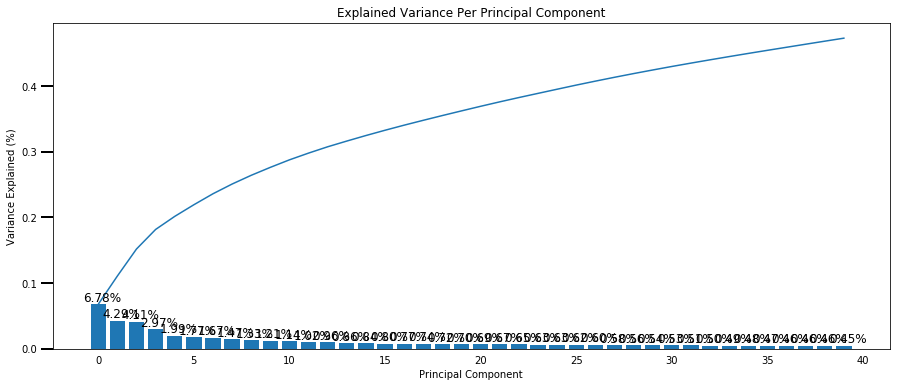

In [42]:
# Re-apply PCA to the data while selecting for number of components to retain.

apca, adf_pca = do_pca(40, adf_scaled)
scree_plot(apca)

In [47]:
print(pca_features_weights(apca, 0, adf_dummy))

PLZ8_ANTG3                    0.139561
KBA13_ANTG3                   0.138751
KBA13_ANTG4                   0.135547
KBA13_BAUMAX                  0.134802
PLZ8_ANTG4                    0.134273
CAMEO_INTL_2015_W             0.129928
LP_STATUS_GROB_1.0            0.128848
HH_EINKOMMEN_SCORE            0.128414
ORTSGR_KLS9                   0.114372
EWDICHTE                      0.114237
FINANZ_HAUSBAUER              0.100390
PLZ8_ANTG2                    0.094159
PLZ8_BAUMAX_Family            0.090357
KBA13_HALTER_30               0.090025
KBA05_ANTG4                   0.088334
KBA13_HALTER_35               0.085520
PLZ8_BAUMAX_Business          0.084685
KBA05_ANTG3                   0.083209
CAMEO_DEUG_2015_9.0           0.082357
VK_DISTANZ                    0.081616
STRUKTURTYP                   0.080149
RELAT_AB                      0.080037
ANZ_HAUSHALTE_AKTIV           0.079723
ANZ_STATISTISCHE_HAUSHALTE    0.078614
KONSUMZELLE                   0.077813
VK_ZG11                  

In [48]:
print(pca_features_weights(apca, 1, adf_dummy))

KBA13_HERST_BMW_BENZ           0.181130
KBA13_SEG_OBEREMITTELKLASSE    0.154953
KBA13_MERCEDES                 0.154739
KBA13_BMW                      0.151144
KBA13_SITZE_4                  0.145079
KBA13_SEG_SPORTWAGEN           0.140392
KBA05_HERST1                   0.129845
KBA13_KMH_211                  0.126051
KBA13_KMH_250                  0.123798
KBA13_KW_121                   0.123173
KBA13_SEG_OBERKLASSE           0.121367
KBA05_KW3                      0.120283
KBA13_CCM_2501                 0.117363
KBA05_MOTOR                    0.110538
KBA13_CCM_3000                 0.109038
KBA13_KRSHERST_BMW_BENZ        0.108034
KBA05_MOD1                     0.106629
KBA05_CCM4                     0.105918
KBA13_CCM_3001                 0.104536
EWDICHTE                       0.098831
KBA13_HALTER_65                0.097730
KBA05_SEG5                     0.096707
STRUKTURTYP                    0.092183
KBA05_MAXHERST_1.0             0.090282
ORTSGR_KLS9                    0.087850


In [ ]:
import pickle
from sklearn.externals import joblib

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
pca_filename = "data/pca.save"
joblib.dump(pca, pca_filename)

In [26]:
#imputer, df_imputed, for_dummies = do_impute(df_cust)
df_dummy = make_dummies(df_cust, for_dummies_c)

Performing get_dummies on the following: ['AKT_DAT_KL', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
***get_dummies finished!


In [33]:
cscaler, cdf_scaled = do_scaling(df_dummy)

Scaling finished!


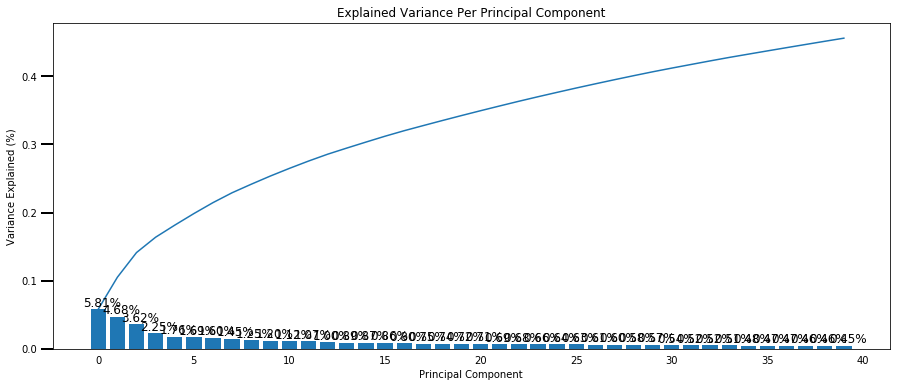

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.

cpca, cdf_pca = do_pca(40, cdf_scaled)
scree_plot(cpca)

In [36]:
print(pca_features_weights(cpca, 0, cdf_scaled))

NameError: name 'df_imputed' is not defined

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_features_weights(pca, 1, cdf_scaled)[:5])

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_features_weights(pca, 2, cdf_scaled)[:5])

in progress
in progress
in progress


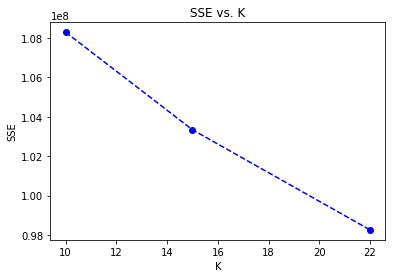

In [51]:
# Over a number of different cluster counts...

#centers = [10, 15, 20, 25, 30]
centers = [10, 15, 22]

scores = []

# run k-means clustering on the data and...
# compute the average within-cluster distances.


for center in centers:
    scores.append(get_kmeans_score(adf_pca, center))
    print('in progress')

    
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [54]:
labels, model = fit_kmeans(adf_pca, 10)

In [53]:
labels_cust, model_cust = fit_kmeans(cdf_pca, 10)

Text(0.5,1,'Customers')

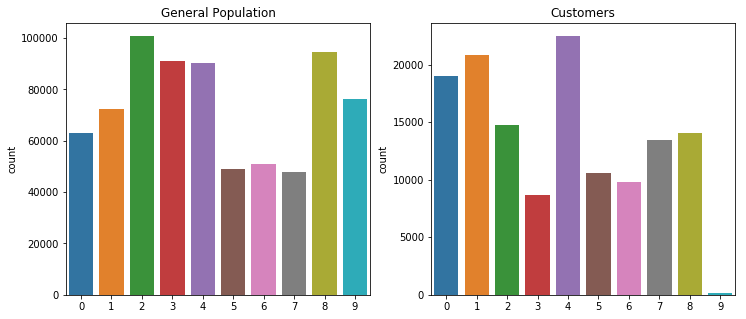

In [55]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axis = plt.subplots(figsize = (12,5), nrows=1, ncols=2)
sns.countplot(labels, ax = axis[0])
sns.countplot(labels_cust, ax = axis[1])
axis[0].set_title('General Population')
axis[1].set_title('Customers')

In [58]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_over = cscaler.inverse_transform(cpca.inverse_transform(model_cust.cluster_centers_[9]))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
customers_over = pd.Series(data = centroid_over, index = df_cust.columns)
print(customers_over[:10])

In [57]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_under = cscaler.inverse_transform(pca_cust.inverse_transform(model_cust.cluster_centers_[13]))
customers_under = pd.Series(data = centroid_under, index = df_cust.columns)
print(customers_under[:10])

NameError: name 'pca_cust' is not defined

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [21]:
import sys
!{sys.executable} -m pip install xgboost

In [23]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', dtype={18:'str',19:'str'})
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str',19:'str'})

feat_info_pickle = pd.read_pickle('data/combined_feat_info_copy.pkl')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [24]:
print(mailout_test.shape, mailout_train.shape, feat_info_pickle.shape, feat_info.shape)

(42833, 366) (42962, 367) (276, 2) (85, 4)


In [26]:
def supervised_ready(df_mailout, feat_info_pickle, feat_info):
    
    df, for_dummies = clean_data(df_mailout, feat_info_pickle, feat_info)
    df_dummy = make_dummies(df, for_dummies)
        
    return df_dummy

In [27]:
mailout_clean = supervised_ready(mailout_train, feat_info_pickle, feat_info)

Before replacement:
sum is: 2217179 percenatge is: 14.0621006308
After replacement:
sum is: 3415532 percenatge is: 21.6624614846
column indices to drop:  [1, 3, 4, 5, 6, 7, 28, 29, 31, 32, 33, 36, 37, 38, 39, 43, 44, 45, 46, 47, 48, 49, 53, 54, 55, 56, 59, 62, 65, 66, 67, 68, 74, 78, 79, 80, 100, 111, 129, 300, 349] 41
['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19_LOTTO', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE', 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_ANZ_12', 'EXTSEL992',

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

OST_WEST_KZ fixed
PRAEGENDE_JUGENDJAHRE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CAMEO_INTL_2015 can be deleted
WOHNLAGE can be deleted


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


PLZ8_BAUMAX can be deleted
EINGEFUEGT_AM is fixed
For get_dummies:     ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'] 9
To delete:           ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'] 4
Columns to delete:  ['VERDICHTUNGSRAUM', 'CAMEO_DEU_2015', 'ANZ_TITEL', 'ANZ_KINDER', 'ANZ_HH_TITEL', 'EINGEFUEGT_AM', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


KBA05_BAUMAX already deleted in the previous steps
CAMEO_DEU_2015 already deleted in the previous steps


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


D19_LETZTER_KAUF_BRANCHE object
Performing get_dummies on the following: ['AKT_DAT_KL', 'GEBAEUDETYP', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'ARBEIT', 'CJT_KATALOGNUTZER', 'CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
***get_dummies finished!


## Start from here******

In [29]:
#mailout_clean.to_pickle('data/mailout_clean.pkl')
mailout_clean_pkl = pd.read_pickle('data/mailout_clean.pkl')

In [30]:
y_train = mailout_clean_pkl['RESPONSE']
X_LNR = mailout_clean_pkl.drop('RESPONSE', axis=1)
X_train = mailout_clean_pkl.drop(['RESPONSE', 'LNR'], axis = 1)
#X_train = mailout_clean.drop('LNR', axis=1)

print(y_train.shape,X_train.shape, X_LNR.shape)

(33739,) (33739, 427) (33739, 428)


In [31]:
scaler = StandardScaler()

# pipeline for scaling and model selection
def get_model(model):   
    
    pipe = Pipeline([('scale', StandardScaler()), 
                      ('Regressor', model)])                  
    return pipe

In [32]:
# for splitting training and testing data
skf = StratifiedKFold(n_splits=5, random_state=28, shuffle=True)
skf.get_n_splits(X_train, y_train)

5

In [33]:
# Apply machine learning pipeline
    
def get_scores(clf, X_train, y_train):    
    
    start = time()
    
    # performs scaling and 
    pipeline = get_model(clf)
    scores = []

    for train_index, test_index in skf.split(X_train, y_train):
        print('train_index length:',len(train_index), 'test_index length', len(test_index))
        
        # data split using StratifiedKFold
        try:
            X_train, X_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
            
#             X_train, X_test = X_train.reindex[train_index], X_train.reindex[test_index]
#             y_train, y_test = y_train.reindex[train_index], y_train.reindex[test_index]

            # training on training data
            pipeline.fit(X_train, y_train)

            # Predictions on test data
            y_pred = pipeline.predict(X_test)

            # gets roc score
            score = roc_auc_score(y_test, y_pred)
            print(model, score)
            scores.append(score)
            
        except:
            print('index out of bound')
        
    end = time()
    print("Finishes in {} seconds.".format(end - start))
    
    return scores

In [34]:
clfs = {'XGBRegressor': XGBRegressor(random_state=28, objective = 'binary:logistic'), 
          'GradientBoostingRegressor': GradientBoostingRegressor(random_state=30), 
          'AdaBoostRegressor': AdaBoostRegressor(random_state=28)
         }

In [35]:
roc_scores = {}
for model, clf in clfs.items():
    
    roc_scores[model] = get_scores(clf, X_train, y_train)

train_index length: 26991 test_index length 6748
XGBRegressor 0.776404342049
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26992 test_index length 6747
index out of bound
Finishes in 59.10625886917114 seconds.
train_index length: 26991 test_index length 6748
GradientBoostingRegressor 0.768575276349
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26992 test_index length 6747
index out of bound
Finishes in 41.91032910346985 seconds.
train_index length: 26991 test_index length 6748
AdaBoostRegressor 0.773654859498
train_index length: 26991 test_index length 6748
index out of bound
train_index length: 26991 test_index length 6748
index out of

In [87]:
roc_scores_df = pd.DataFrame(roc_scores)
roc_scores_df.columns = list(roc_scores.keys())
roc_scores_df

XGBRegressor  GradientBoostingRegressor  AdaBoostRegressor
0      0.773389                   0.788567           0.786566

In [94]:
def get_grid_best(clf, p , X, y):
    
    start = time()
    
    grid = GridSearchCV(estimator = get_model(clf),
                       param_grid = p, scoring='roc_auc', n_jobs=-1, iid=False, cv=5)
    
    grid.fit(X, y)
    print('best score: ',grid.best_score_, 'best parameter',grid.best_params_ , 'best estimator', grid.best_estimator_)
    
    end = time()
    print("GridSearch finished in {} seconds.".format(end - start))
    
    return grid.best_estimator_

In [96]:
# Create initial model
clf_0 = XGBRegressor(
    objective = 'binary:logistic', #logistic regression for binary classification
    scale_pos_weight = 1, #because of high class imbalance
    random_state = 28)

In [97]:
pipeline = Pipeline([
        ('scale', scaler),
        ('clf', clf_0)
])

parameters_1 = {
    'clf__max_depth': range(3,10,2),
    'clf__min_child_weight': range(1,6,2)
}

cv = GridSearchCV(estimator=pipeline, param_grid=parameters_1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(X_train, y_train)
cv.grid_scores_, cv.best_params_, cv.best_score_

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61661, std: 0.03275, params: {'clf__max_depth': 3, 'clf__min_child_weight': 1},
  mean: 0.60201, std: 0.00980, params: {'clf__max_depth': 3, 'clf__min_child_weight': 3},
  mean: 0.57872, std: 0.03432, params: {'clf__max_depth': 3, 'clf__min_child_weight': 5},
  mean: 0.60214, std: 0.01767, params: {'clf__max_depth': 5, 'clf__min_child_weight': 1},
  mean: 0.56836, std: 0.02938, params: {'clf__max_depth': 5, 'clf__min_child_weight': 3},
  mean: 0.61740, std: 0.05118, params: {'clf__max_depth': 5, 'clf__min_child_weight': 5},
  mean: 0.63551, std: 0.00545, params: {'clf__max_depth': 7, 'clf__min_child_weight': 1},
  mean: 0.57978, std: 0.01575, params: {'clf__max_depth': 7, 'clf__min_child_weight': 3},
  mean: 0.57396, std: 0.03137, params: {'clf__max_depth': 7, 'clf__min_child_weight': 5},
  mean: 0.60737, std: 0.04535, params: {'clf__max_depth': 9, 'clf__min_child_weight': 1},
  mean: 0.59095, std: 0.02389, params: {'clf__max_depth': 9, 'clf__min_child_weight': 3},
  mean: 0.

In [98]:
grid_parameters = {
    'clf__max_depth':range(3,10,1),
    'clf__min_child_weight':range(1,6,1)
}


clf_0 = XGBRegressor(
    objective = 'binary:logistic', #logistic regression for binary classification
    scale_pos_weight = 1, #because of high class imbalance
    random_state = 28)

# clf = XGBRegressor(objective= 'binary:logistic',
#                    random_state = 30,
#                    scale_pos_weight = 1)

best_estimator = get_grid_best(clf_0, grid_parameters, X_train, y_train)

ValueError: Invalid parameter clf for estimator Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Regressor', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
   ..._pos_weight=1, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
def classifier_roc(clf, param_grid, X=X, y=y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')